"""
Improved Disease Prediction using Microbiome Data

Key Improvements:
1. XGBoost-only approach (removed PyCaret)
2. Both PCA and UMAP visualizations
3. Enhanced feature selection with multiple methods
4. Class balancing via random subsampling of healthy controls
5. Cross-validation with stratified folds
6. Feature importance analysis
7. Better evaluation metrics and visualization
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score, recall_score, 
                             precision_score, f1_score, cohen_kappa_score,
                             matthews_corrcoef, confusion_matrix, classification_report)
from scipy.stats import zscore, kruskal, mannwhitneyu
from tqdm import tqdm
import random
import warnings
import xgboost as xgb
import umap

warnings.filterwarnings('ignore')

/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/umap/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*80)
print("MICROBIOME DISEASE CLASSIFICATION - IMPROVED VERSION")
print("="*80)

MICROBIOME DISEASE CLASSIFICATION - IMPROVED VERSION


In [6]:
# Download abundance data from GMrepo

import os
import urllib.request

# List of files to download with their URLs
files_to_download = [
    ("superkingdom2descendents.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "taxonomy table"),
    ("samples_loaded.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "sample table"),
    ("sample_to_run_info.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample run"),
    ("species_abundance.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "abundance table")
]

for filename, url, description in files_to_download:
    if not os.path.exists(filename):
        print(f"Downloading {description}...")
        urllib.request.urlretrieve(url, filename)
        print(f"{description} download finished")
    else:
        print(f"{filename} already exists, skipping download")

taxonomy table download finished
sample table download finished
sample run download finished
abundance table download finished


In [8]:
import gzip
import shutil

def decompress_gz(gz_file):
    """Decompress a .gz file"""
    output_file = gz_file.replace('.gz', '')
    
    with gzip.open(gz_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed: {gz_file} -> {output_file}")

# List of files to decompress
files_to_decompress = [
    "superkingdom2descendents.txt.gz",
    "samples_loaded.txt.gz",
    "sample_to_run_info.txt.gz",
    "species_abundance.txt.gz"
]

for file in files_to_decompress:
    decompress_gz(file)

Decompressed: superkingdom2descendents.txt.gz -> superkingdom2descendents.txt
Decompressed: samples_loaded.txt.gz -> samples_loaded.txt
Decompressed: sample_to_run_info.txt.gz -> sample_to_run_info.txt
Decompressed: species_abundance.txt.gz -> species_abundance.txt


In [9]:
# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("\n[1/8] Loading data...")

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype='str')

print(f"✓ Loaded {len(abundance_raw)} abundance records")
print(f"✓ Loaded {len(taxonomy_table)} taxonomy entries")
print(f"✓ Loaded {len(sample_table)} samples")



[1/8] Loading data...
✓ Loaded 5541271 abundance records
✓ Loaded 5195 taxonomy entries
✓ Loaded 108176 samples


In [10]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n[2/8] Preprocessing abundance data...")

# Filter to genus level
abundance_genus = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

# Pivot table: samples as rows, taxa as columns
pivoted_df = abundance_genus.pivot_table(
    index='loaded_uid', 
    columns='ncbi_taxon_id', 
    values='relative_abundance', 
    fill_value=0
)

# Rename columns with genus names
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))
pivoted_df.rename(columns=mapping, inplace=True)

print(f"✓ Created abundance matrix: {pivoted_df.shape}")



[2/8] Preprocessing abundance data...
✓ Created abundance matrix: (68723, 2214)


In [11]:
# ============================================================================
# 3. METADATA CLEANING
# ============================================================================
print("\n[3/8] Cleaning metadata...")

# Merge metadata tables
metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

# Quality filters
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]
print(f"  - Removed {len(metadata_df[metadata_df['QCStatus'] == 0])} low-quality samples")

# Remove phenotypes with < 100 samples
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]
print(f"  - Kept {len(phenotypes_to_keep)} phenotypes with ≥100 samples")

# Standardize phenotype names
metadata_df['phenotype'] = metadata_df['phenotype'].replace(
    ['healthy', 'Health', 'Normal'], 'Healthy'
)
metadata_df['phenotype'] = metadata_df['phenotype'].replace(
    ['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease'
)

# Remove duplicates
non_phenotype_columns = metadata_df.columns.difference(['phenotype'])
duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]
print(f"  - Removed {duplicated_rows.sum()} duplicate rows")



[3/8] Cleaning metadata...
  - Removed 0 low-quality samples
  - Kept 64 phenotypes with ≥100 samples
  - Removed 0 duplicate rows


In [12]:
# ============================================================================
# 4. ABUNDANCE DATA CLEANING
# ============================================================================
print("\n[4/8] Cleaning abundance data...")

# Keep only samples in metadata
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[pivoted_df.index.isin(uids_to_keep)]

# Remove unknown column (first column)
pivoted_df_filtered = pivoted_df_filtered.iloc[:, 1:]

# Verify alignment
metadata_df = metadata_df.set_index('uid').loc[pivoted_df_filtered.index].reset_index()
pivoted_df_filtered = pivoted_df_filtered.reset_index(drop=True)
metadata_df = metadata_df.reset_index(drop=True)

print(f"✓ Final dataset: {len(pivoted_df_filtered)} samples × {len(pivoted_df_filtered.columns)} features")



[4/8] Cleaning abundance data...
✓ Final dataset: 57391 samples × 2213 features


In [14]:
# ============================================================================
# 5. HEALTHY SAMPLES - OUTLIER REMOVAL
# ============================================================================
print("\n[5/8] Processing healthy samples and removing outliers...")

# Subset healthy samples
healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"].copy()
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_metadata.index].copy()

# Reset indices to align
pivoted_df_Healthy = pivoted_df_Healthy.reset_index(drop=True)
healthy_metadata = healthy_metadata.reset_index(drop=True)

# Standardize and perform PCA
scaler = StandardScaler()
healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(healthy_standardized)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Identify outliers using Z-scores
z_scores = zscore(pca_df)
outlier_threshold = 3
outliers = (np.abs(z_scores) > outlier_threshold).any(axis=1)

print(f"  - Identified {outliers.sum()} outliers in healthy samples")

# Remove outliers
pivoted_df_Healthy = pivoted_df_Healthy[~outliers].reset_index(drop=True)
healthy_metadata = healthy_metadata[~outliers].reset_index(drop=True)

print(f"✓ Clean healthy samples: {len(pivoted_df_Healthy)}")



[5/8] Processing healthy samples and removing outliers...
  - Identified 36 outliers in healthy samples
✓ Clean healthy samples: 29558



[6/8] Creating visualizations...
  - Computing UMAP (this may take a few minutes)...
✓ Saved: healthy_samples_pca_umap.png


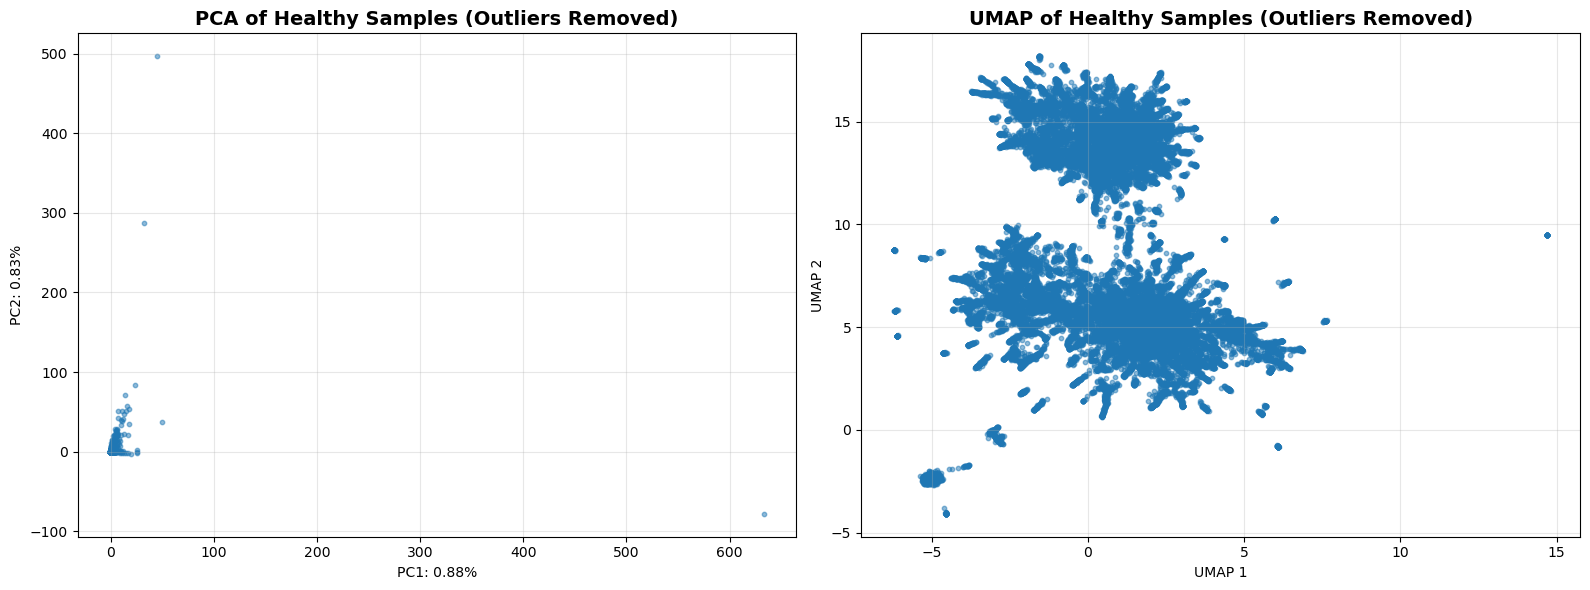

In [15]:
# ============================================================================
# 6. VISUALIZATION - HEALTHY SAMPLES (PCA + UMAP)
# ============================================================================
print("\n[6/8] Creating visualizations...")

# Re-standardize after outlier removal
healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(healthy_standardized)

# UMAP
print("  - Computing UMAP (this may take a few minutes)...")
umap_reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
umap_result = umap_reducer.fit_transform(healthy_standardized)

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, s=10)
axes[0].set_title('PCA of Healthy Samples (Outliers Removed)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1: {pca.explained_variance_ratio_[0]*100:.2f}%')
axes[0].set_ylabel(f'PC2: {pca.explained_variance_ratio_[1]*100:.2f}%')
axes[0].grid(alpha=0.3)

# UMAP plot
axes[1].scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5, s=10)
axes[1].set_title('UMAP of Healthy Samples (Outliers Removed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('healthy_samples_pca_umap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: healthy_samples_pca_umap.png")


In [21]:
# ============================================================================
# 7. DISEASE CLASSIFICATION LOOP
# ============================================================================
print("\n[7/8] Training disease classifiers...")

# Separate disease samples
non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"].reset_index(drop=True)
pivoted_df_non_Healthy = pivoted_df_filtered.loc[metadata_df[metadata_df["phenotype"] != "Healthy"].index].reset_index(drop=True)

# Storage for results
all_results = []
feature_importance_dict = {}

# Get list of diseases
diseases = non_healthy_metadata['phenotype'].unique()
print(f"\nProcessing {len(diseases)} diseases...")

for disease in tqdm(diseases, desc="Disease classification"):
    
    print(f"\n{'='*80}")
    print(f"Processing: {disease}")
    print(f"{'='*80}")
    
    # ========================================================================
    # 7.1 Subset disease samples
    # ========================================================================
    is_disease = non_healthy_metadata['phenotype'] == disease
    disease_data = pivoted_df_non_Healthy[is_disease].copy().reset_index(drop=True)
    disease_labels = non_healthy_metadata[is_disease].copy().reset_index(drop=True)
    
    n_disease = len(disease_data)
    n_healthy = len(pivoted_df_Healthy)
    
    print(f"  Disease samples: {n_disease}")
    print(f"  Healthy samples: {n_healthy}")
    
    # ========================================================================
    # 7.2 Balance classes by subsampling healthy controls
    # ========================================================================
    # Randomly subsample healthy samples to match disease sample count
    healthy_indices = np.random.choice(
        len(pivoted_df_Healthy), 
        size=n_disease, 
        replace=False
    )
    
    balanced_healthy_data = pivoted_df_Healthy.iloc[healthy_indices].copy().reset_index(drop=True)
    balanced_healthy_labels = healthy_metadata.iloc[healthy_indices].copy().reset_index(drop=True)
    
    print(f"  Balanced healthy samples: {len(balanced_healthy_data)}")
    print(f"  ✓ Classes balanced (1:1 ratio)")
    
    # ========================================================================
    # 7.3 Feature selection using multiple methods
    # ========================================================================
    print("  Performing feature selection...")
    
    # Convert columns to list to ensure proper iteration
    column_list = list(pivoted_df_Healthy.columns)
    
    # Method 1: Kruskal-Wallis test (univariate non-parametric)
    kw_features = []
    kw_pvalues = []
    
    for col in column_list:
        # Check for sufficient variance
        try:
            healthy_unique = len(balanced_healthy_data[col].unique())
            disease_unique = len(disease_data[col].unique())
            if healthy_unique > 1 and disease_unique > 1:
                _, p_value = kruskal(balanced_healthy_data[col], disease_data[col])
                if p_value < 0.05:
                    kw_features.append(col)
                    kw_pvalues.append(p_value)
        except:
            continue
    
    # Method 2: Mann-Whitney U test (more robust for small samples)
    mw_features = []
    mw_pvalues = []
    
    for col in column_list:
        try:
            healthy_unique = len(balanced_healthy_data[col].unique())
            disease_unique = len(disease_data[col].unique())
            if healthy_unique > 1 and disease_unique > 1:
                _, p_value = mannwhitneyu(balanced_healthy_data[col], disease_data[col], alternative='two-sided')
                if p_value < 0.05:
                    mw_features.append(col)
                    mw_pvalues.append(p_value)
        except:
            continue
    
    # Combine features from both methods (union)
    selected_features = list(set(kw_features) | set(mw_features))
    
    # If too many features, select top N by combined p-value ranking
    MAX_FEATURES = 500
    if len(selected_features) > MAX_FEATURES:
        # Create combined p-value ranking
        feature_scores = {}
        for feat in selected_features:
            kw_p = kw_pvalues[kw_features.index(feat)] if feat in kw_features else 1.0
            mw_p = mw_pvalues[mw_features.index(feat)] if feat in mw_features else 1.0
            feature_scores[feat] = min(kw_p, mw_p)  # Take best p-value
        
        # Select top features
        selected_features = sorted(feature_scores.keys(), key=lambda x: feature_scores[x])[:MAX_FEATURES]
    
    print(f"  Selected features: {len(selected_features)}")
    
    # If no significant features found, use top 100 by variance
    if len(selected_features) < 10:
        print("  Warning: Few significant features found, using top variance features")
        combined_data = pd.concat([balanced_healthy_data, disease_data])
        variances = combined_data.var()
        selected_features = variances.nlargest(100).index.tolist()
    
    # Filter data to selected features
    balanced_healthy_filtered = balanced_healthy_data[selected_features].copy()
    disease_filtered = disease_data[selected_features].copy()
    
    # ========================================================================
    # 7.4 Combine and prepare data
    # ========================================================================
    X = pd.concat([balanced_healthy_filtered, disease_filtered]).reset_index(drop=True)
    y_labels = pd.concat([balanced_healthy_labels, disease_labels])['phenotype'].reset_index(drop=True)
    y = (y_labels != "Healthy").astype(int)  # Binary: 0=Healthy, 1=Disease
    
    print(f"  Final dataset shape: {X.shape}")
    print(f"  Class distribution: Healthy={sum(y==0)}, {disease}={sum(y==1)}")
    
    # ========================================================================
    # 7.5 Visualizations (PCA + UMAP)
    # ========================================================================
    scaler_viz = StandardScaler()
    X_scaled = scaler_viz.fit_transform(X)
    
    # PCA
    pca_viz = PCA(n_components=2)
    pca_coords = pca_viz.fit_transform(X_scaled)
    
    # UMAP
    umap_viz = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
    umap_coords = umap_viz.fit_transform(X_scaled)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = ['#2E86AB' if label == 0 else '#A23B72' for label in y]
    labels_str = ['Healthy' if label == 0 else disease for label in y]
    
    # PCA
    for label_val, label_str, color in zip([0, 1], ['Healthy', disease], ['#2E86AB', '#A23B72']):
        mask = y == label_val
        axes[0].scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
                       c=color, label=label_str, alpha=0.6, s=30)
    axes[0].set_title(f'PCA: Healthy vs {disease}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(f'PC1: {pca_viz.explained_variance_ratio_[0]*100:.2f}%')
    axes[0].set_ylabel(f'PC2: {pca_viz.explained_variance_ratio_[1]*100:.2f}%')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # UMAP
    for label_val, label_str, color in zip([0, 1], ['Healthy', disease], ['#2E86AB', '#A23B72']):
        mask = y == label_val
        axes[1].scatter(umap_coords[mask, 0], umap_coords[mask, 1], 
                       c=color, label=label_str, alpha=0.6, s=30)
    axes[1].set_title(f'UMAP: Healthy vs {disease}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save with safe filename
    safe_disease_name = disease.replace('/', '_').replace(' ', '_')
    plt.savefig(f'{safe_disease_name}_pca_umap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ========================================================================
    # 7.6 XGBoost Training with Cross-Validation
    # ========================================================================
    print("  Training XGBoost classifier...")
    
    # Define XGBoost model with optimal parameters
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        eval_metric='logloss',
        n_jobs=-1
    )
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    scoring = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1'
    }
    
    cv_results = cross_validate(
        xgb_model, X, y, cv=cv, scoring=scoring, 
        return_train_score=False, n_jobs=-1
    )
    
    # Train final model on full data
    xgb_model.fit(X, y)
    
    # Get predictions
    y_pred = xgb_model.predict(X)
    y_pred_proba = xgb_model.predict_proba(X)[:, 1]
    
    # Calculate metrics
    results = {
        'Disease': disease,
        'N_Disease': n_disease,
        'N_Healthy_Balanced': len(balanced_healthy_data),
        'N_Features': len(selected_features),
        'CV_Accuracy_Mean': cv_results['test_accuracy'].mean(),
        'CV_Accuracy_Std': cv_results['test_accuracy'].std(),
        'CV_ROC_AUC_Mean': cv_results['test_roc_auc'].mean(),
        'CV_ROC_AUC_Std': cv_results['test_roc_auc'].std(),
        'CV_Recall_Mean': cv_results['test_recall'].mean(),
        'CV_Recall_Std': cv_results['test_recall'].std(),
        'CV_Precision_Mean': cv_results['test_precision'].mean(),
        'CV_Precision_Std': cv_results['test_precision'].std(),
        'CV_F1_Mean': cv_results['test_f1'].mean(),
        'CV_F1_Std': cv_results['test_f1'].std(),
        'Train_Accuracy': accuracy_score(y, y_pred),
        'Train_ROC_AUC': roc_auc_score(y, y_pred_proba),
        'Train_Recall': recall_score(y, y_pred),
        'Train_Precision': precision_score(y, y_pred),
        'Train_F1': f1_score(y, y_pred),
        'Train_Kappa': cohen_kappa_score(y, y_pred),
        'Train_MCC': matthews_corrcoef(y, y_pred)
    }
    
    all_results.append(results)
    
    # Store feature importance
    feature_importance_dict[disease] = pd.DataFrame({
        'feature': selected_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"  ✓ CV ROC-AUC: {results['CV_ROC_AUC_Mean']:.4f} ± {results['CV_ROC_AUC_Std']:.4f}")
    print(f"  ✓ CV F1: {results['CV_F1_Mean']:.4f} ± {results['CV_F1_Std']:.4f}")


[7/8] Training disease classifiers...

Processing 62 diseases...


Disease classification:   0%|                            | 0/62 [00:00<?, ?it/s]


Processing: Obesity
  Disease samples: 383
  Healthy samples: 29558
  Balanced healthy samples: 383
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 127
  Final dataset shape: (766, 127)
  Class distribution: Healthy=383, Obesity=383
  Training XGBoost classifier...


Disease classification:   2%|▎                   | 1/62 [00:32<33:16, 32.72s/it]

  ✓ CV ROC-AUC: 0.8832 ± 0.0255
  ✓ CV F1: 0.8200 ± 0.0160

Processing: Diabetic Retinopathy
  Disease samples: 188
  Healthy samples: 29558
  Balanced healthy samples: 188
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 71
  Final dataset shape: (376, 71)
  Class distribution: Healthy=188, Diabetic Retinopathy=188
  Training XGBoost classifier...


Disease classification:   3%|▋                   | 2/62 [01:02<30:52, 30.87s/it]

  ✓ CV ROC-AUC: 0.9593 ± 0.0232
  ✓ CV F1: 0.8769 ± 0.0439

Processing: Glomerulonephritis, IGA
  Disease samples: 152
  Healthy samples: 29558
  Balanced healthy samples: 152
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 97
  Final dataset shape: (304, 97)
  Class distribution: Healthy=152, Glomerulonephritis, IGA=152
  Training XGBoost classifier...


Disease classification:   5%|▉                   | 3/62 [01:29<28:53, 29.38s/it]

  ✓ CV ROC-AUC: 0.9464 ± 0.0134
  ✓ CV F1: 0.8538 ± 0.0138

Processing: Schizophrenia
  Disease samples: 277
  Healthy samples: 29558
  Balanced healthy samples: 277
  ✓ Classes balanced (1:1 ratio)
  Performing feature selection...
  Selected features: 134
  Final dataset shape: (554, 134)
  Class distribution: Healthy=277, Schizophrenia=277
  Training XGBoost classifier...


Disease classification:   5%|▉                   | 3/62 [01:35<31:13, 31.76s/it]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 750, in inner_f
    return func(**kwargs)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/sklearn.py", line 1789, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/sklearn.py", line 702, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/sklearn.py", line 1259, in _create_dmatrix
    return QuantileDMatrix(
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 750, in inner_f
    return func(**kwargs)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 1744, in __init__
    self._init(
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 1808, in _init
    it.reraise()
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 593, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 574, in _handle_exception
    return fn()
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 661, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/data.py", line 1632, in next
    input_data(**self.kwargs)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 750, in inner_f
    return func(**kwargs)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 650, in input_data
    self.proxy.set_info(
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 750, in inner_f
    return func(**kwargs)
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 1065, in set_info
    self.feature_names = feature_names
  File "/home/cesc/miniconda3/envs/microbiome_classif/lib/python3.10/site-packages/xgboost/core.py", line 1494, in feature_names
    raise ValueError(
ValueError: feature_names must be string, and may not contain [, ] or <


In [ ]:
# ============================================================================
# 8. RESULTS ANALYSIS
# ============================================================================
print("\n[8/8] Analyzing results...")

results_df = pd.DataFrame(all_results)

# Save results
results_df.to_csv('xgboost_classification_results.csv', index=False)
print("✓ Saved: xgboost_classification_results.csv")

# Filter for good models (CV ROC-AUC > 0.70 and CV F1 > 0.60)
good_models = results_df[
    (results_df['CV_ROC_AUC_Mean'] > 0.70) & 
    (results_df['CV_F1_Mean'] > 0.60)
].copy()

print(f"\n✓ Found {len(good_models)} diseases with good classification performance")

if len(good_models) > 0:
    # Sort by ROC-AUC
    good_models = good_models.sort_values('CV_ROC_AUC_Mean', ascending=False)
    
    # Display top results
    print("\nTop 10 Best Classified Diseases:")
    print("="*80)
    display_cols = ['Disease', 'CV_ROC_AUC_Mean', 'CV_F1_Mean', 'CV_Precision_Mean', 'CV_Recall_Mean']
    print(good_models[display_cols].head(10).to_string(index=False))
    
    # ========================================================================
    # Visualization: Performance metrics
    # ========================================================================
    top_n = min(15, len(good_models))
    top_models = good_models.head(top_n)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # ROC-AUC
    axes[0, 0].barh(range(len(top_models)), top_models['CV_ROC_AUC_Mean'], 
                     xerr=top_models['CV_ROC_AUC_Std'], color='steelblue', alpha=0.8)
    axes[0, 0].set_yticks(range(len(top_models)))
    axes[0, 0].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[0, 0].set_xlabel('ROC-AUC Score', fontweight='bold')
    axes[0, 0].set_title('Cross-Validation ROC-AUC', fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].axvline(0.8, color='red', linestyle='--', alpha=0.5, label='0.8 threshold')
    axes[0, 0].legend()
    
    # F1 Score
    axes[0, 1].barh(range(len(top_models)), top_models['CV_F1_Mean'], 
                     xerr=top_models['CV_F1_Std'], color='coral', alpha=0.8)
    axes[0, 1].set_yticks(range(len(top_models)))
    axes[0, 1].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[0, 1].set_xlabel('F1 Score', fontweight='bold')
    axes[0, 1].set_title('Cross-Validation F1 Score', fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].axvline(0.7, color='red', linestyle='--', alpha=0.5, label='0.7 threshold')
    axes[0, 1].legend()
    
    # Precision
    axes[1, 0].barh(range(len(top_models)), top_models['CV_Precision_Mean'], 
                     xerr=top_models['CV_Precision_Std'], color='seagreen', alpha=0.8)
    axes[1, 0].set_yticks(range(len(top_models)))
    axes[1, 0].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[1, 0].set_xlabel('Precision', fontweight='bold')
    axes[1, 0].set_title('Cross-Validation Precision', fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Recall
    axes[1, 1].barh(range(len(top_models)), top_models['CV_Recall_Mean'], 
                     xerr=top_models['CV_Recall_Std'], color='purple', alpha=0.8)
    axes[1, 1].set_yticks(range(len(top_models)))
    axes[1, 1].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[1, 1].set_xlabel('Recall', fontweight='bold')
    axes[1, 1].set_title('Cross-Validation Recall', fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.suptitle('XGBoost Classification Performance - Top Diseases', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('classification_performance_summary.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: classification_performance_summary.png")
    
    # ========================================================================
    # Feature importance for top disease
    # ========================================================================
    if len(good_models) > 0:
        top_disease = good_models.iloc[0]['Disease']
        top_features = feature_importance_dict[top_disease].head(20)
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_features)), top_features['importance'], color='darkblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
        plt.xlabel('Feature Importance', fontweight='bold')
        plt.title(f'Top 20 Features for {top_disease}', fontweight='bold', fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'feature_importance_{top_disease.replace("/", "_").replace(" ", "_")}.png', 
                    dpi=300, bbox_inches='tight')
        print(f"✓ Saved: feature importance plot for {top_disease}")


In [ ]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Files Generated:")
print("  1. xgboost_classification_results.csv - Complete results for all diseases")
print("  2. healthy_samples_pca_umap.png - Visualization of healthy cohort")
print("  3. [disease]_pca_umap.png - PCA/UMAP for each disease")
print("  4. classification_performance_summary.png - Performance metrics overview")
print("  5. feature_importance_*.png - Top features for best disease")
print("\nSummary Statistics:")
print(f"  Total diseases analyzed: {len(results_df)}")
print(f"  Diseases with good performance (AUC>0.7, F1>0.6): {len(good_models)}")
if len(good_models) > 0:
    print(f"  Best disease: {good_models.iloc[0]['Disease']}")
    print(f"  Best ROC-AUC: {good_models.iloc[0]['CV_ROC_AUC_Mean']:.4f}")
    print(f"  Best F1: {good_models.iloc[0]['CV_F1_Mean']:.4f}")
print("="*80)